# Capstone Project 3: Preprocessing & Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
final_df = pd.read_csv('final_df.csv')
final_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df = final_df.copy()

## Preprocessing

In [4]:
# Separating the target from from other features

X = df.drop(columns='stroke')
y = df['stroke']

In [5]:
# Defining categorical and numerical columns

cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = ['age', 'avg_glucose_level', 'bmi']


# ColumnTranformer for preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

In [6]:
# Fitting and transforming features
X_processed = preprocessor.fit_transform(X)

# New feature names
ohe_feat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
final_feat_names = num_cols + list(ohe_feat_names) + ['hypertension', 'heart_disease']

X_processed_df = pd.DataFrame(X_processed, columns=final_feat_names)

X_processed_df.head()

,age,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease
0,1.051434,2.706375,1.005086,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.786070,2.121559,-0.098981,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.626390,-0.005028,0.472536,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.255342,1.437358,0.719327,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.582163,1.501184,-0.631531,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [7]:
# Checking the numerical columns to see if they are properly scaled
# Should have mean ~ 0 and STD ~ 1
X_processed_df[num_cols].describe().T[['mean','std']]

,mean,std
age,5.005781e-17,1.000098
avg_glucose_level,1.001156e-16,1.000098
bmi,-4.449583e-17,1.000098


X has been successfully scaled and is ready for train-test-splitting.

**Train-test-splitting**

In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42, stratify=y 
)

# Before applying SMOTE
print('Stroke distribution in y_train:', Counter(y_train))

# After applying SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print('Balanced stroke distribution in y_train:', Counter(y_train_balanced))

Stroke distribution in y_train: Counter({0: 3889, 1: 199})
Balanced stroke distribution in y_train: Counter({0: 3889, 1: 3889})


## Modeling

In a medical setting it is important to catch as many true positive/reduce false negative stroke cases. So we will need to look to **recall** as our leading metric for model choice consideration.

### Logistic Regression

Calssification Report:               precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022

Confusion Matrix: [[726 246]
 [ 10  40]]
ROC AUC Score: 0.8446502057613168


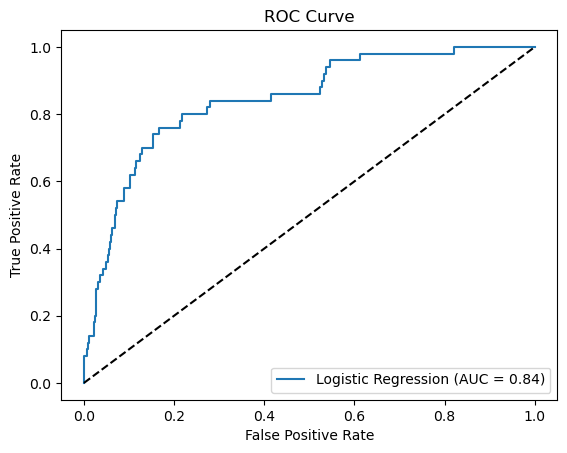

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Initializing and fitting 
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_balanced, y_train_balanced)

# Predicting
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

# Evaluating
print(f'Calssification Report: {classification_report(y_test, y_pred)}')
print(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba)}')

# Plotting ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

- The **recall** for stroke cases looks to be pretty strong at 0.80.
- The **precistion** for stroke cases of 0.14, which is expected for class imbalance even after balancing during training.
- **ROC AUC** of 0.845 looks promising. Model can distinguish stroke and no-stroke cases even if precision is low.

**Tuning Logistic model**

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1,10,100],
    'solver':['liblinear'],
    'class_weight':[None, 'balanced']
}

# GridSearchCV
log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_balanced, y_train_balanced)

# Best Model
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:,1]


# Evaluation
print(f'Best Parameters: {grid.best_params_}')
print(f'Confusion Matrix: {confusion_matrix(y_test, y_pred_best)}')
print(f'Classification Report: {classification_report(y_test, y_pred_best)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_best)}')

Best Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Confusion Matrix: [[706 266]
 [  9  41]]
Classification Report:               precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.82      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.73      0.81      1022

ROC AUC Score: 0.8402057613168724


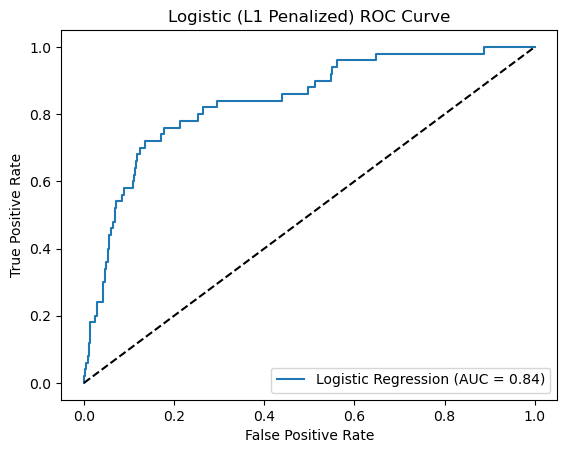

In [49]:
# Plotting ROC curve

fprb, tprb, thresholds = roc_curve(y_test, y_proba_best)
plt.figure()
plt.plot(fprb, tprb, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_best)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic (L1 Penalized) ROC Curve')
plt.legend()
plt.savefig('log_L1_roc_curve.jpg')
plt.show()

In [22]:
log_class_rep = classification_report(y_test, y_pred_best, output_dict=True)

- **C = 0.01** helps reduce overfitting and simplifying the model.
- **class_weight = None** likely means SMOTE did it's job.
- **Recall** did slightly better going up to **0.82**
- **ROC AUC**, **overall accuracy**, and **F1-score** for stroke predictions dipped slightly, likely due to simplifying the model with C = 0.01.
- Although the model is a bit more conservative than the baseline model, but still strong discriminatory power.

**Random Forest**

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Parameter Grid
param_grid_rf = {
    'n_estimators':[100,200],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2],
    'class_weight':[None, 'balanced']
}

# Grid Search
rf_cl = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf_cl, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_balanced, y_train_balanced)

# Best model evaluation
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

# Evaluation
print(f'Best Parameters: {grid_rf.best_params_}')
print(f'Confusion matrix: {confusion_matrix(y_test, y_pred_rf)}')
print(f'Classification Report: {classification_report(y_test, y_pred_rf)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_rf)}')

Best Parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Confusion matrix: [[942  30]
 [ 42   8]]
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.97      0.96       972
           1       0.21      0.16      0.18        50

    accuracy                           0.93      1022
   macro avg       0.58      0.56      0.57      1022
weighted avg       0.92      0.93      0.92      1022

ROC AUC Score: 0.7677057613168723


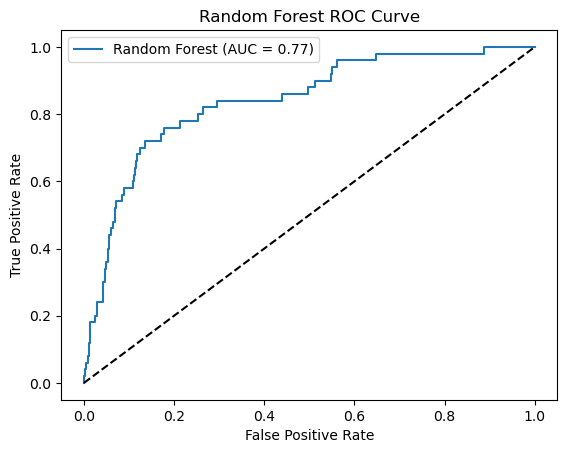

In [44]:
# Plotting ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
plt.figure()
plt.plot(fprb, tprb, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_rf)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.savefig('random_forest_roc_curve.jpg')
plt.show()

In [23]:
rf_class_rep = classification_report(y_test, y_pred_rf, output_dict=True)

- It is good at predicting no-stroke cases (**class 0 precision = 0.97**), but performs poorly with predicting stroke cases (**class 1 recall = 0.16**).
- **ROC AUC** dropped quite a bit too. Model looks to struggle more than the Logistic Regression at separating stroke and no-stroke cases.

**Gradient Boosting Classifier**

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

# Param Grid for Gradient Boosting
param_grid_gb = {
    'n_estimators':[100,200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,5],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,2]
}

# Setting up model and running CV
gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='f1', n_jobs=-1)
grid_gb.fit(X_train_balanced, y_train_balanced)

# Best model evaluation
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
y_proba_gb = best_gb.predict_proba(X_test)[:,1]

# Evaluation
print(f'Best Parameters: {grid_gb.best_params_}')
print(f'Confusion matrix: {confusion_matrix(y_test, y_pred_gb)}')
print(f'Classification Report: {classification_report(y_test, y_pred_gb)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_gb)}')

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Confusion matrix: [[952  20]
 [ 43   7]]
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.98      0.97       972
           1       0.26      0.14      0.18        50

    accuracy                           0.94      1022
   macro avg       0.61      0.56      0.57      1022
weighted avg       0.92      0.94      0.93      1022

ROC AUC Score: 0.7876748971193415


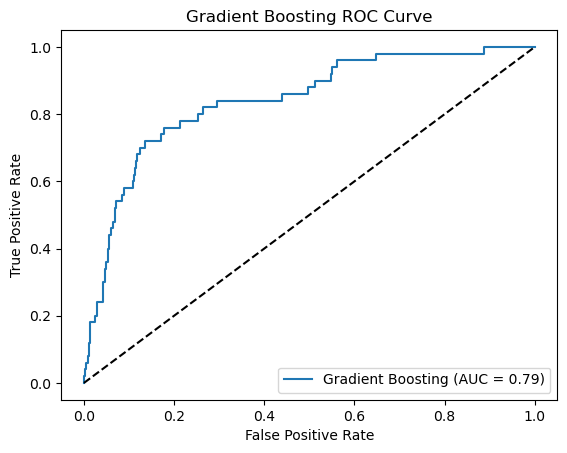

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_gb)
plt.figure()
plt.plot(fprb, tprb, label='Gradient Boosting (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_gb)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.legend()
plt.savefig('gradient_boosting_roc_curve.jpg')
plt.show()

In [24]:
gb_class_rep = classification_report(y_test, y_pred_gb, output_dict=True)

- GBR model has the highest overall accuracy.
- Still has a lower ROC AUC score than Logistic Regression
- Still a very poor recall with class 1 (stroke) like Random Forest.
- Like RF, they are a bit more precise with predicting stroke, are far less sensitive to predicting actual stroke cases.

## Feature importance

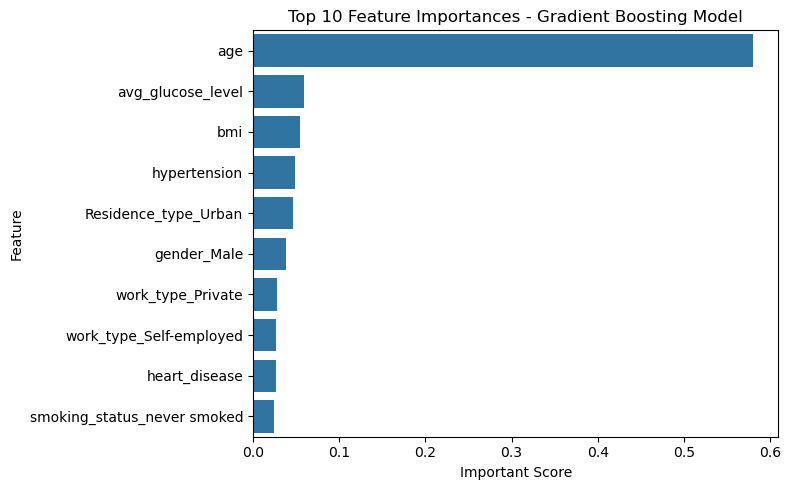

In [47]:
# Gradient Boosting model
# Based on the best parameters
best_gb = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)
best_gb.fit(X_train_balanced, y_train_balanced)

# Feature importances for Gradient Boosting
feature_importances_gb = pd.Series(best_gb.feature_importances_, index=X_train_balanced.columns)
top_features_gb = feature_importances_gb.sort_values(ascending=False).head(10)

# Plotting the feature importances
plt.figure(figsize=(8,5))
sns.barplot(x=top_features_gb.values, y=top_features_gb.index)
plt.title('Top 10 Feature Importances - Gradient Boosting Model')
plt.xlabel('Important Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('gb_top10_feats.jpg')
plt.show()

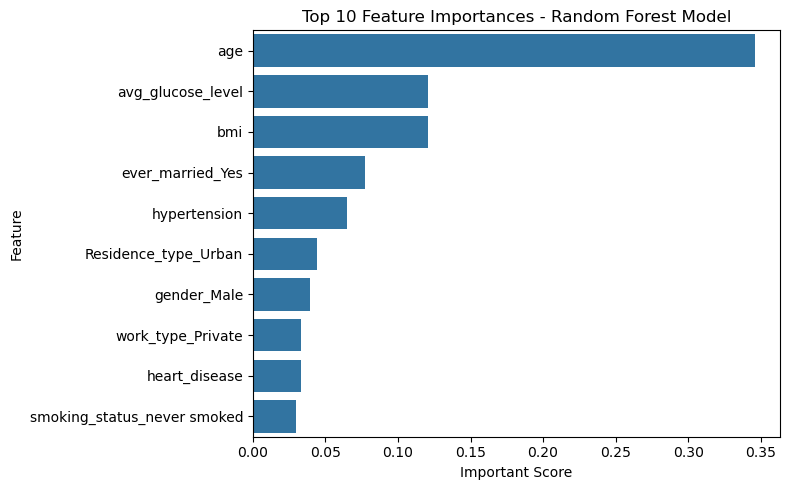

In [48]:
# Random Forest
best_rf = RandomForestClassifier(
    class_weight=None,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Feature importances for Random Forest
best_rf.fit(X_train_balanced, y_train_balanced)
feature_importances_rf = pd.Series(best_rf.feature_importances_, index=X_train_balanced.columns)
top_features_rf = feature_importances_rf.sort_values(ascending=False).head(10)

# Plotting the feature importances
plt.figure(figsize=(8,5))
sns.barplot(x=top_features_rf.values, y=top_features_rf.index)
plt.title('Top 10 Feature Importances - Random Forest Model')
plt.xlabel('Important Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('rf_top10_feats.jpg')
plt.show()

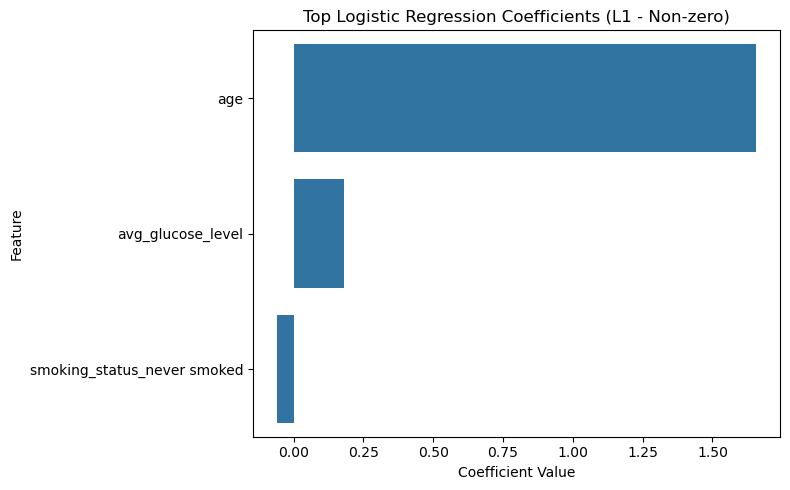

In [50]:
# Logistic Regression
best_log = LogisticRegression(
    max_iter=1000,
    C=0.01,
    penalty='l1',
    class_weight=None,
    solver='liblinear', 
    random_state=42)

best_log.fit(X_train_balanced, y_train_balanced)

# Non-zero coefficients
coefficients = pd.Series(best_log.coef_[0], index=X_train_balanced.columns)
non_zero_coeffs = coefficients[coefficients != 0].sort_values(key=np.abs, ascending=False)

# Plotting the feature importances
plt.figure(figsize=(8,5))
sns.barplot(x=non_zero_coeffs.values, y=non_zero_coeffs.index)
plt.title('Top Logistic Regression Coefficients (L1 - Non-zero)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('log_non_zero_coefs.jpg')
plt.show() 

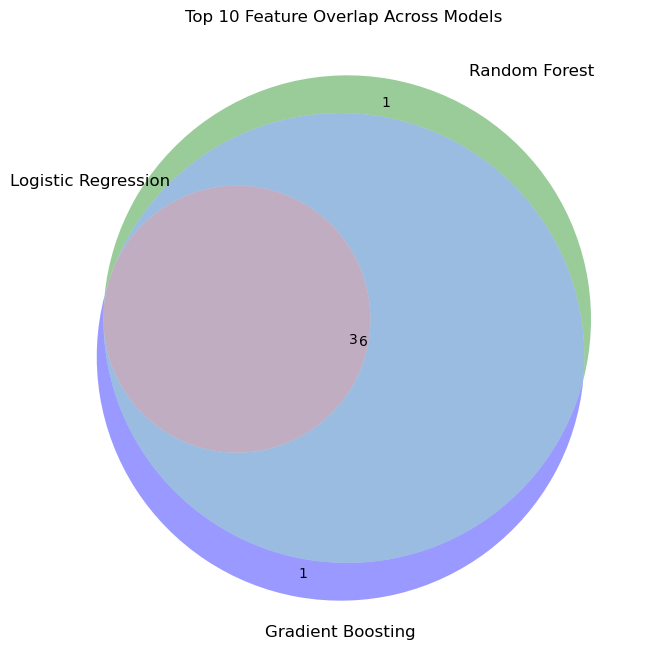

{'log_reg_top10': ['age', 'avg_glucose_level', 'smoking_status_never smoked'],
 'rf_top10': age                            0.346011
 avg_glucose_level              0.120777
 bmi                            0.120688
 ever_married_Yes               0.076938
 hypertension                   0.064570
 Residence_type_Urban           0.044227
 gender_Male                    0.039392
 work_type_Private              0.033368
 heart_disease                  0.033260
 smoking_status_never smoked    0.029637
 dtype: float64,
 'gb_top10': age                            0.580347
 avg_glucose_level              0.058908
 bmi                            0.054574
 hypertension                   0.049285
 Residence_type_Urban           0.046459
 gender_Male                    0.038673
 work_type_Private              0.028079
 work_type_Self-employed        0.026957
 heart_disease                  0.026403
 smoking_status_never smoked    0.024107
 dtype: float64}

In [20]:
# Venn Diagram for comparing top features across the models
from matplotlib_venn import venn3

log_reg_top10 = coefficients[coefficients != 0].abs().sort_values(ascending=False).head(10).index.tolist()
rf_top10 = pd.Series(best_rf.feature_importances_, index=X_train_balanced.columns).sort_values(ascending=False).head(10).index.tolist()
gb_top10 = pd.Series(best_gb.feature_importances_, index=X_train_balanced.columns).sort_values(ascending=False).head(10).index.tolist()

plt.figure(figsize=(10,8))

venn3(
    [set(log_reg_top10), set(rf_top10), set(gb_top10)],
    set_labels=('Logistic Regression', 'Random Forest', 'Gradient Boosting')
)
plt.title('Top 10 Feature Overlap Across Models')
plt.show()

overlap_sets = {
    'log_reg_top10': log_reg_top10,
    'rf_top10': top_features_rf,
    'gb_top10': top_features_gb
}

overlap_sets

**Age** and **avg_glucose_level** are the strongest predictors of stroke risk across all 3 models.

## Model Performance Overview

In [26]:
model_metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Recall (Stroke)': [log_class_rep['1']['recall'], rf_class_rep['1']['recall'], gb_class_rep['1']['recall']],
    'Precision (Stroke)':[log_class_rep['1']['precision'], rf_class_rep['1']['precision'], gb_class_rep['1']['precision']],
    'ROC AUC':[roc_auc_score(y_test, y_proba_best), roc_auc_score(y_test, y_proba_rf), roc_auc_score(y_test, y_proba_gb)],
})

model_metrics_df

,Model,Recall (Stroke),Precision (Stroke),ROC AUC
0,Logistic Regression,0.82,0.133550,0.840206
1,Random Forest,0.16,0.210526,0.767706
2,Gradient Boosting,0.14,0.259259,0.787675


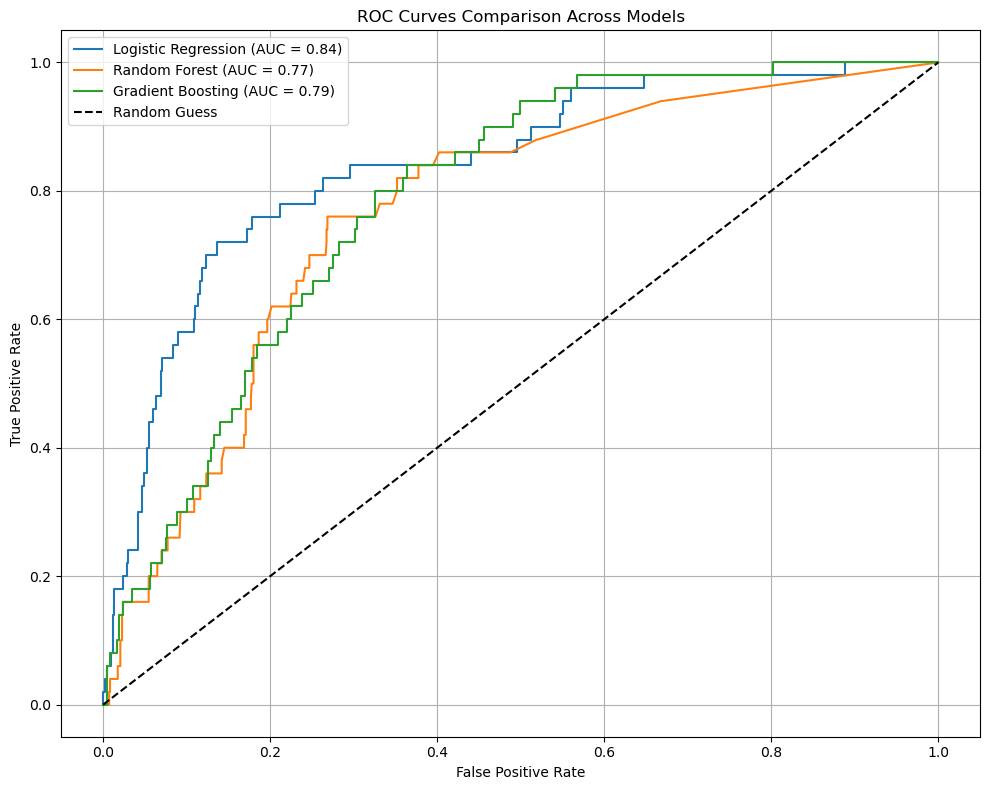

In [38]:
# ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_best)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_best):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})")
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {roc_auc_score(y_test, y_proba_gb):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison Across Models")
plt.legend()
plt.grid(True)
plt.savefig('Models ROC Curves.jpg')
plt.tight_layout()
plt.show()

In a medical setting, we need to minimize false negatives. The **Logistic Regression (L1 Penalized)** model has both the highest **recall** for stroke cases and the best performing **ROC AUC**. This will be our model of choice.

In [51]:
# Saving model
import joblib

joblib.dump(best_log, 'logistic_model_stroke_predictions.pkl')

['logistic_model_stroke_predictions.pkl']